[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/104_cfd_metodos_num/104_cfd_metodos_num.ipynb)

# Métodos numéricos

Lo primero que tenemos que tener en cuenta a la hora de resolver ecuaciones diferenciales mediante métodos numéricos es la manera en la que vamos a representar la solución aproximada (la cual puede estar influenciada por las propiedades de la ecuación). En los posts sobre PBDL utilizamos una red neuronal para aproximar esta solución. En este post, y los siguientes, usaremos técnicas más tradicionales entre las que se encuentras los métodos de elementos finitos, volúmenes finitos o diferencias finitas. Vamos a introducir estos métodos en la resolución de nuestra ecuación conservativa

$$
\phi_t + f(\phi)_x = 0
$$

## Diferencias finitas

El método de las diferencias finitas consiste en representar el dominio computacional (es decir, el espacio considerado en el que vamos a resolver la ecuación) mediante un conjunto de puntos. La solución se representa de manera local mediante un polinomio.

$$
\phi(x,t) = \sum_{l=0}^{2} a_l(t)(x - x^k)^l
$$
$$
f(x,t) = \sum_{l=0}^{2} b_l(t)(x - x^k)^l
$$

La ecuación se satisface de manera puntual

$$
\phi_t(x^k,t) + \frac{f(x^{k+1}, t) - f(x^{k-1}, t)}{h^k + h^{k+1}} = 0
$$

Estos métodos son relativamente simples de entender e implementar en malla estructuradas, son de alto orden, pueden ser integrados en el tiempo de manera explícita y existe muchísima literatura sobre ellos desde los años 60. Sin embargo, su implementación se complica en geometrías complejas y no funcionan en problemas que presenten discontinuidades.

## Elementos finitos

El método de los elementos finitos consiste en discretizar el dominio mediante una serie de elementos no superpuestos en los cuales se representa la solución de manera global mediante polinomios continuos a trozos.

$$
\phi(x) = \sum_{k=1}^K \phi(x_k,t)N^k(x)
$$

La ecuación se satisface de manera global

$$
\int_{\Omega_k} (\phi_t + f_x)N^j(x)dx=0
$$

Debido a la formulación, estos métodos son implícitos y su eficiencia en esquemas de integración temporal explícitos no es buena. Por otro lado, son métodos robustos, aptos para geometrías complejas y de alto orden. Por sus propiedades, son muy usados en problemas elípticos (deformación de estructuras, por ejemplo) pero su aplicación en problemas hiperbólicos no es tan popular. 

## Volúmenes finitos

En el caso del método de volúmenes finitos, el dominio se discretiza en un conjunto de celdas (o volúmenes) que no se sobreponen entre ellas y la solución se representa de manera local como el promediado volumétrico de la magnitud conservativa.

$$
\hat{\phi}(x^k, t) = \frac{1}{V^k} \int_{\Omega^k} \phi(x,t) dx
$$

La ecuación se satisface en su forma conservativa

$$ 
V^k \hat{\phi}_t^k + f(x^{k+1/2}, t) - f(x^{k - 1/2}, t) = 0
$$

Lo cual requiere de la reconstrucción de funciones de flujo en las caras de las celdas

$$
f(x^{k+1/2}) = F(\phi^k, \phi^{k+1})
$$

Estos métodos son robustos y aplicables en geometrías complejas, aptos para problemas hiperbólicos (en los que pueden aparecer discontinuidades), respetan las propiedades conservativas de la ecuación y también gozan de amplia literatura desde los años 70. Su principal ventaja es la imposibilidad de reconstruir soluciones de alto orden.

## Métodos Galerkin

Los métodos Galerkin combinan las mejores ideas de los volúmenes finitos con las de los elementos finitos. Seguiremos representado la solución global como la unión de las soluciones locales en las celdas pero usando polinomios de alto orden dentro de cada celda en vez de un promediado. Estos métodos son de alto orden, conservativos localmente, explícitos, adaptativos y aplicables a problemas hiperbólicos. Su principal desventaja es su alto coste computacional y poca literatura disponible. Exploraremos el uso de estos métodos más adelante, ya que son mis favoritos :)

![tabla](./tabla.png)

## Solución numérica de la ecuación de convección

De entre las alternativas, vamos a centrarnos en el uso de volúmenes finitos ya que son los más adecuados y estudiados para el tipo de problemas a los que nos enfrentaremos (la simulación de fluidos). Para ello vamos a resolver la ecuación de convección de manera numérica mediante estos métodos. En el post anterior ya vimos esta ecuación

$$
\phi_t + u \phi_x = 0
$$

y su solución analítica 

$$
\phi(x,t) = \phi_0(x - ut)
$$

Disponer de una solución analítica nos va bien para poder comparar con los resultados numéricos y así descubrir propiedades interesantes de los mismos.

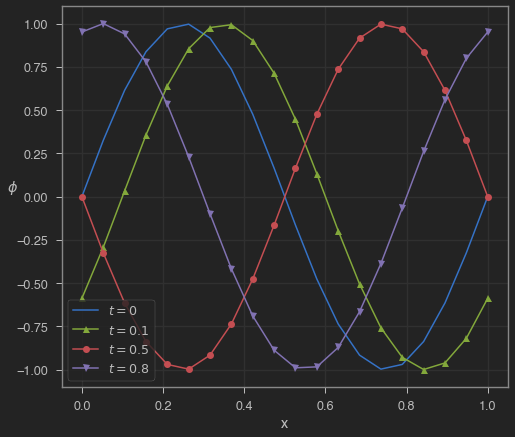

In [8]:
import numpy as np 
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 20)
p = np.sin(2 * np.pi * x)

u, t = 1, 0.1
p1 = np.sin(2 * np.pi * (x - u*t)) 

u, t = 1, 0.5
p2 = np.sin(2 * np.pi * (x - u*t)) 

u, t = 1, 0.8
p3 = np.sin(2 * np.pi * (x - u*t ))

plt.plot(x, p)
plt.plot(x, p1, '^-')
plt.plot(x, p2, 'o-')
plt.plot(x, p3, 'v-')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.legend(['$t = 0$', '$t = 0.1$', '$t = 0.5$', '$t = 0.8$'])
plt.grid(True)
plt.show()

Lo primero que necesitamos es discretizar nuestro dominio en celdas. Estas celdas estarán conectadas entre ellas a través de sus caras.


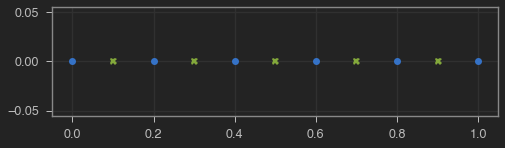

In [9]:
def geom(N, x0=0, x1=1):
	f = np.linspace(x0, x1, N+1)
	c = np.array([0.5*(f[i] + f[i+1]) for i in range(N)])
	return f, c

f, c = geom(5)

plt.figure(figsize=(8, 2))
plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.grid(True)
plt.show()

Nuestra solución global estará representada como los promedios en cada una de las celdas, una función a trozos.

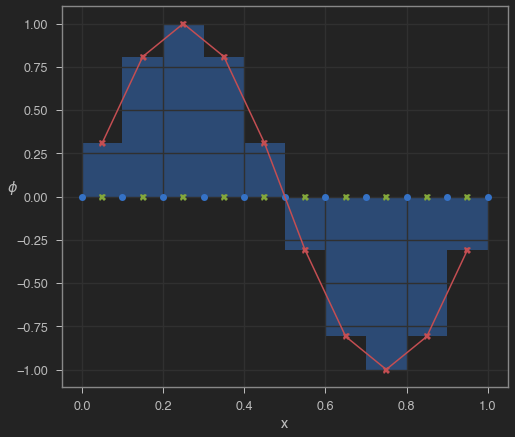

In [10]:
f, c = geom(10)
p0 = np.sin(2 * np.pi * c)

plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.plot(c, p0, 'X-')
plt.bar(c, p0, width=0.1, alpha=0.5)
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.show()

> Para ser estrictos deberíamos usar el valor resultantes de integrar $\phi(x, 0)$ entre las caras de cada celda, pero a efector prácticos da lo mismo.

Nuestro objetivo es el de conocer como evoluciona $\phi(x,t)$. Al ser $\phi$ una variable conservativa, y al mantener esta propiedad en cada una de las celdas, ésta solo puede variar debido al flujo de $\phi$ a través de las caras (sumando lo que entra y restando lo que sale). 

$$ 
\phi_t^k = \frac{u \phi(x^{k - 1/2}, t) - u \phi(x^{k + 1/2}, t)}{V^k}
$$

Sin embargo, como puedes observar en la gráfica, no tenemos un único valor de $\phi$ en las caras. Aquí es donde entra en juego el concepto de **esquema numérico**, el cual decidirá cómo aproximamos este valor. En el siguiente post entraremos en más detalle en este concepto, por ahora simplemente usaremos el valor *aguas arriba*

$$
\phi(x^{k + 1/2}, t) = u^+ \phi(x^{k}, t) + u^- \phi(x^{k+1}, t)
$$

> $u^+$ será igual a $u$ siempre que $u > 0$, mientras que $u^-$ será igual a $u$ siempre que $u < 0$. Si $u = 0$, cualquier valor es válido.

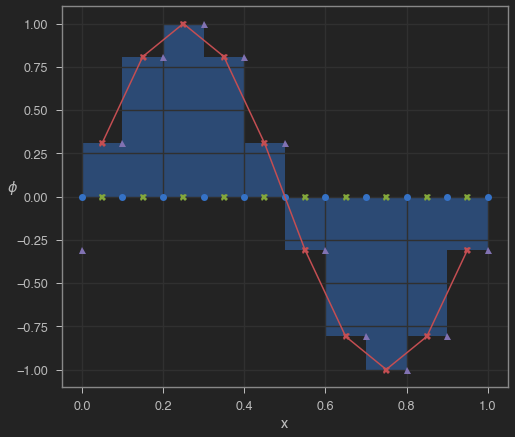

In [11]:
F = np.zeros(len(f))
u = 1

F[1:-1] = [u*(u > 0)*p0[i] + u*(u < 0)*p0[i+1] for i in range(len(f[1:-1]))]
F[0] = F[-1] = u*(u > 0)*p0[-1] + u*(u < 0)*p0[0]

plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.plot(c, p0, 'X-')
plt.bar(c, p0, width=0.1, alpha=0.5)
plt.plot(f, F, '^')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.show()

Una vez calculados los flujos podemos encontrar el valor de $\phi(x, t + \Delta t)$ utilizando cualquier esquema de integración temporal (lo cual veremos también en detalle en futuros posts). En este caso, usamos un esquema simple de primer orden

$$
\phi_t = \frac{\phi(x, t + \Delta t) - \phi(x, t )}{\Delta t}
$$ 

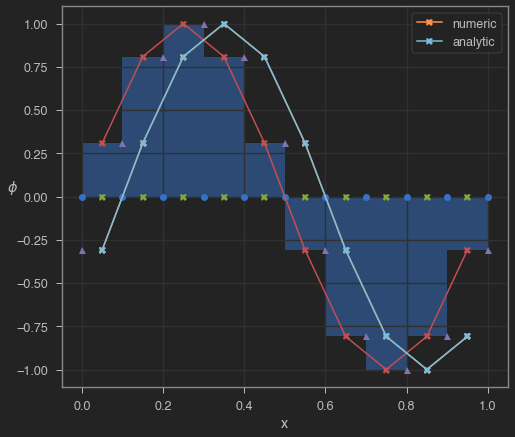

In [12]:
pt = np.array([(F[i+1] - F[i])/(f[i+1] - f[i]) for i in range(len(c))])

dt = 0.1
p1 = p0 - dt*pt

plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.plot(c, p0, 'X-')
plt.bar(c, p0, width=0.1, alpha=0.5)
plt.plot(f, F, '^')
plt.plot(c, p1, 'X-', label='numeric')
p1a = np.sin(2 * np.pi * (c - u*dt ))
plt.plot(c, p1a, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.legend()
plt.show()

Como puedes observar nuestra solución se ha movido hacia la derecha (lo cual es el comportamiento esperado según la solución analítica). Y no solo eso, sin o que lo ha hecho la cantidad exacta. Esto se debe a la sencillez de este problema y el conjunto de parámetros usados (número de celdas, esquema numérico, salto temporal) pero esto nunca pasa en la práctica, y siempre vamos a introducir algún tipo de error. Por ejemplo, usando un salto temporal ligeramente diferente

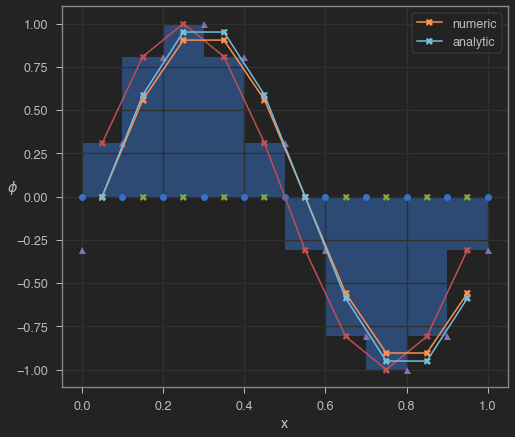

In [13]:
dt = 0.05
p1 = p0 - dt*pt

plt.plot(f, np.zeros(f.shape[0]), 'o')
plt.plot(c, np.zeros(c.shape[0]), 'X')
plt.plot(c, p0, 'X-')
plt.bar(c, p0, width=0.1, alpha=0.5)
plt.plot(f, F, '^')
plt.plot(c, p1, 'X-', label='numeric')
p1a = np.sin(2 * np.pi * (c - u*dt ))
plt.plot(c, p1a, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.legend()
plt.show()

El siguiente código nos permite resolver nuestro problema de manera iterativa. Utilízalo para jugar con los diferentes parámetros a ver qué resultados obtienes. Te invito a aplicar los conceptos físicos vistos hasta ahora para intentar entender qué pasa en cada ocasión (si no quieres, puedes pasar al siguiente post en el que lo veremos).

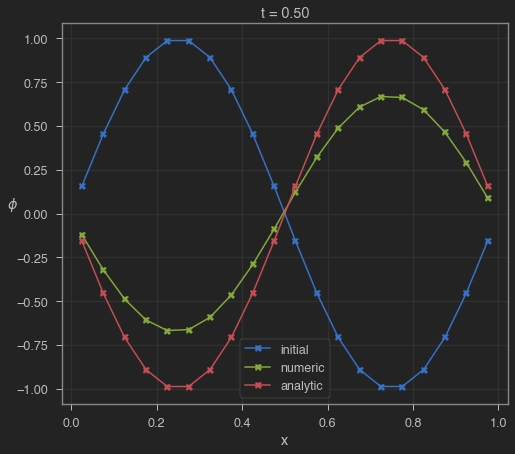

In [14]:
# parmámetros
f, c = geom(20)
u, dt, t, tf = 1, 0.01, 0, 0.5

# condiciones iniciales
p0 = np.sin(2 * np.pi * c)
p = p0.copy()

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	# flujos, asumiendo u > 0
	F = np.zeros(len(f))
	F[1:-1] = [u*(u > 0)*p[i] + u*(u < 0)*p[i+1] for i in range(len(f[1:-1]))]
	F[0] = F[-1] = u*(u > 0)*p[-1] + u*(u < 0)*p[0] # condición de contorno

	# nuevo valor
	pt = np.array([(F[i+1] - F[i])/(f[i+1] - f[i]) for i in range(len(c))])
	p = p - dt*pt

plt.plot(c, p0, 'X-', label='initial')
plt.plot(c, p, 'X-', label='numeric')
pa = np.sin(2 * np.pi * (c - u*t ))
plt.plot(c, pa, 'X-', label='analytic')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f't = {t:.2f}')
plt.grid(True)
plt.legend()
plt.show()